In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [30]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [32]:
# We can view all of the classes that automap found
Base.classes.keys()

m_columns = inspector.get_columns('measurement')
s_columns = inspector.get_columns('station')

for column in m_columns:
    print(column["name"], column["type"])
    
print("--------")
for column in s_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [33]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session = Session(engine)
engine.execute('SELECT * FROM Measurement LIMIT 15').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0)]

# Exploratory Climate Analysis

## Precipitation Analysis

In [48]:
## select and define start and end dates for the trip
#start_date = '2020-05-01'
#end_date = '2020-05-15'

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
prcp2017 = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date.between("2016-08-23", "2017-08-23")).\
group_by(Measurement.date).all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp2017_df = pd.DataFrame(prcp2017)
prcp2017_df = prcp2017_df.rename(columns = {"prcp" : "Precipitation", "date" : "Date"})
prcp2017_df = prcp2017_df.set_index('Date')
prcp2017_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


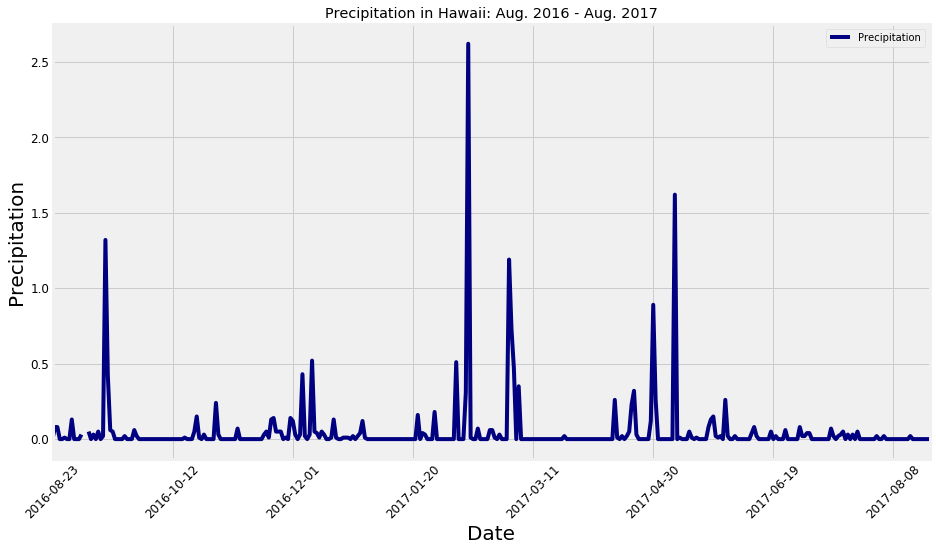

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
x_labels = ['2016-08','2016-09','2016-10','2016-11','2016-12',
           '2017-01','2017-02','2017-03','2017-04','2017-05',
           '2017-06','2017-07','2017-08']

prcp2017_df.plot(figsize=(14,8),
                 use_index=True, 
                 rot=45,
                 title= 'Precipitation in Hawaii: Aug. 2016 - Aug. 2017',
                 legend=True,
                 fontsize=12,
                 grid=True,
                 color='navy')

plt.xlabel('Date', fontsize=20)
plt.ylabel('Precipitation', fontsize=20)
plt.savefig('12mo_precipitation_plot')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_desc = prcp2017_df.describe()
prcp_desc

,Precipitation
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


## Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.id).count()
print(f'There are {stations} weather stations in Hawaii.')


There are 9 weather stations in Hawaii.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Station.station, Station.name, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_station = pd.DataFrame(station_activity, columns =['ID', 'Name', 'Recordings']) 
active_station = active_station.set_index('ID')

print(f'The most active weather station is:')
print(active_station.iloc[0])
active_station

The most active weather station is:
Name          WAIHEE 837.5, HI US
Recordings                   2772
Name: USC00519281, dtype: object


,Name,Recordings
ID,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [15]:
# Using the station id from the previous query, 
# calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature 
# of the most active station?
waihee_temp = session.query(Measurement.station, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').all()

waihee_df = pd.DataFrame(waihee_temp, columns=['ID','Temperature'])
waihee_df = waihee_df.set_index('ID')
waihee = waihee_df.describe()
#waihee_df
waihee


print(f'Tempearture recording at the Waihee Weather Station:')
print(waihee)





Tempearture recording at the Waihee Weather Station:
       Temperature
count  2772.000000
mean     71.663781
std       4.357642
min      54.000000
25%      69.000000
50%      72.000000
75%      74.000000
max      85.000000


In [16]:

# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

waihee_2017 = session.query(Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date.between("2016-08-23", "2017-08-23")).all()
wai_temp = [temp[0] for temp in waihee_2017]

# waiyear_df = pd.DataFrame(waihee_2017)
# waiyear_df.head()


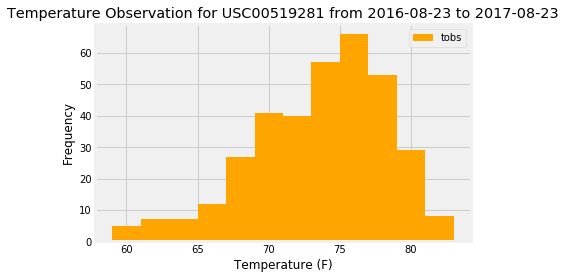

In [17]:
#plot the results as a histogram
plt.hist(wai_temp, bins=12, facecolor='orange')
plt.title("Temperature Observation for USC00519281 from 2016-08-23 to 2017-08-23")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Temperature (F)')
labels = ['tobs']
plt.legend(labels)
plt.savefig('histogram_station_temperature_observation')
plt.show()

## Temeprture Analysis

In [18]:
# This function called `calc_temps` 
# will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures 
# for that range of dates
start_date = '2017-05-01'
end_date = '2017-05-15'
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.  
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d       
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Decided to get data for each year available
start_dates = ['2017-05-01','2016-05-01','2015-05-01','2014-05-01','2013-05-01','2012-05-01','2011-05-01','2010-05-01']
end_dates = ['2017-05-15','2016-05-15', '2015-05-15', '2014-05-15', '2013-05-15', '2012-05-15', '2011-05-15', '2010-05-15']

dates = zip(start_dates, end_dates)
years= ['2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']

averages = []

for s,e in dates:
    print(calc_temps(s,e))
    averages.append(calc_temps(s,e))
    
    
    


[(65.0, 75.23809523809524, 80.0)]
[(65.0, 73.08510638297872, 79.0)]
[(66.0, 73.67, 79.0)]
[(65.0, 72.64220183486239, 79.0)]
[(64.0, 72.98214285714286, 84.0)]
[(63.0, 71.74257425742574, 79.0)]
[(65.0, 72.72881355932203, 79.0)]
[(65.0, 73.48780487804878, 80.0)]


In [20]:
print(averages)

[[(65.0, 75.23809523809524, 80.0)], [(65.0, 73.08510638297872, 79.0)], [(66.0, 73.67, 79.0)], [(65.0, 72.64220183486239, 79.0)], [(64.0, 72.98214285714286, 84.0)], [(63.0, 71.74257425742574, 79.0)], [(65.0, 72.72881355932203, 79.0)], [(65.0, 73.48780487804878, 80.0)]]


In [21]:
# create lists to hold the data
# loop through response to extract min, max and mean temperatures for each year
mins = []
means = []
maxs = []
for average in averages:
    for i,j,k in average:
        mins.append(i)
        means.append(j)
        maxs.append(k)
        
# create list to calculate error bars for each year
range = zip(maxs, mins)

error = []

for h,l in range:
        print(h)
        print (l)
        print("----")
        error.append(h-l)

print(error)



80.0
65.0
----
79.0
65.0
----
79.0
66.0
----
79.0
65.0
----
84.0
64.0
----
79.0
63.0
----
79.0
65.0
----
80.0
65.0
----
[15.0, 14.0, 13.0, 14.0, 20.0, 16.0, 14.0, 15.0]


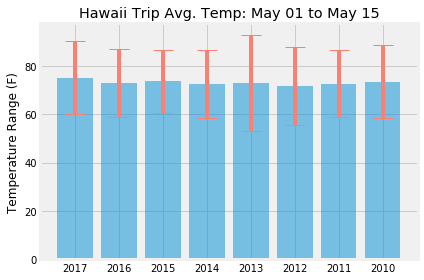

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Build the plot
fig, ax = plt.subplots()
ax.bar(years, means, yerr=error, align='center', alpha=0.5, ecolor='salmon', capsize=10)
ax.set_ylabel('Temperature Range (F)')
ax.set_xticks(years)
ax.set_xticklabels(years)
ax.set_title("Hawaii Trip Avg. Temp: May 01 to May 15")
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## Precipitation Analysis

In [23]:
# Calculate the total amount of rainfall per weather station 
# for your trip dates using the previous year's matching dates.

total_rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).\
                               label('total precipitation')).\
filter(Measurement.station == Station.station, Measurement.date >= start_date, Measurement.date <= end_date).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

# Sort this in descending order by precipitation amount 
# and list the station, name, latitude, longitude, and elevation

total_rainfall_df= pd.DataFrame(total_rainfall)
total_rainfall_df

,station,name,latitude,longitude,elevation,total precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.51
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.20
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.29
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.94
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.87
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.32


# Climate App